# 📊 Batch Visitor Forecast

**Purpose**: Generate detailed visitor forecasts with visualizations for planning

**When to Run**: 
- Weekly (Sundays) for next week's planning
- Before holidays for extended forecasts
- Ad-hoc for special events

**Outputs**:
- Detailed day-by-day forecasts
- Staffing recommendations
- Visualizations for stakeholders
- Logged predictions for later validation


In [6]:
# ============================================================================
# SETUP
# ============================================================================
import sys
sys.path.insert(0, '..')  # Add parent for local imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json
import warnings
warnings.filterwarnings('ignore')

# Snowflake imports
from snowflake.ml.registry import Registry
from snowflake.snowpark import Session
from snowflake.snowpark.context import get_active_session

# Use our FeatureEngineer for consistency with training!
from models.feature_engineer import FeatureEngineer

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ Imports loaded")


✅ Imports loaded


In [7]:
# Get Snowflake session (works in Snowsight notebooks)
try:
    session = get_active_session()
    print(f"✅ Connected to Snowflake")
    print(f"   Database: {session.get_current_database()}")
    print(f"   Schema: {session.get_current_schema()}")
    print(f"   Warehouse: {session.get_current_warehouse()}")
except:
    # Fallback for local development
    print("⚠️ Running locally - using connection config")
    import toml
    from pathlib import Path
    
    config_path = Path.home() / '.snowflake' / 'config.toml'
    sf_config = toml.load(config_path)
    conn_config = sf_config.get('connections', {}).get('snowflake_agents', {})
    
    session = Session.builder.configs({
        'account': conn_config.get('account'),
        'user': conn_config.get('user'),
        'password': conn_config.get('password'),
        'database': 'SKI_RESORT_DB',
        'schema': 'MARTS',
        'warehouse': conn_config.get('warehouse', 'COMPUTE_WH')
    }).create()
    print(f"✅ Connected locally")


✅ Connected to Snowflake
   Database: "SKI_RESORT_DB"
   Schema: "MARTS"
   Warehouse: "COMPUTE_WH"


In [8]:
# ============================================================================
# CONFIGURATION
# ============================================================================
FORECAST_START = datetime.now().date() + timedelta(days=1)  # Start tomorrow
FORECAST_DAYS = 14  # Two weeks ahead

print(f"📅 Forecast Configuration:")
print(f"   Start Date: {FORECAST_START}")
print(f"   End Date: {FORECAST_START + timedelta(days=FORECAST_DAYS-1)}")
print(f"   Days: {FORECAST_DAYS}")


📅 Forecast Configuration:
   Start Date: 2025-12-04
   End Date: 2025-12-17
   Days: 14


## 1. Load Model from Registry


In [9]:
# ============================================================================
# LOAD MODEL FROM REGISTRY
# ============================================================================
registry = Registry(session, database_name="SKI_RESORT_DB", schema_name="MODELS")

# Get the visitor forecast model
model = registry.get_model("VISITOR_FORECASTER")
model_version = model.default

print(f"🤖 Model Loaded:")
print(f"   Name: VISITOR_FORECASTER")
print(f"   Version: {model_version.version_name}")

# Show model metrics if available
try:
    metrics = model_version.get_metrics()
    if metrics:
        print(f"\n📊 Model Metrics:")
        for k, v in metrics.items():
            print(f"   {k}: {v:.4f}" if isinstance(v, float) else f"   {k}: {v}")
except:
    pass


🤖 Model Loaded:
   Name: VISITOR_FORECASTER
   Version: SOLID_BADGER_4


## 2. Prepare Features


In [10]:
# ============================================================================
# LOAD FEATURE ENGINEER & GET HISTORICAL DATA
# ============================================================================
# Use same config as training for consistency!
fe = FeatureEngineer.from_config('visitor_forecast')

print(f"📋 Model Config: {fe.model_name}")
print(f"   Features: {len(fe.get_feature_columns())}")
print(f"   Lags: {fe.lag_config.get('lags', [])}")

# Get training query from config (single source of truth)
query = fe.get_training_query(database='SKI_RESORT_DB', schema='MARTS', years_back=1)
raw_df = session.sql(query).to_pandas()

# Engineer features (same as training)
hist_df = fe.engineer(raw_df)
feature_cols = fe.get_feature_columns(hist_df)

# Calculate recent averages for lag features
recent_avg = hist_df['UNIQUE_VISITORS'].tail(7).mean()
recent_30_avg = hist_df['UNIQUE_VISITORS'].tail(30).mean()

print(f"\n📈 Historical Data:")
print(f"   Records: {len(hist_df)}")
print(f"   Recent 7-day avg: {recent_avg:.0f} visitors")
print(f"   Recent 30-day avg: {recent_30_avg:.0f} visitors")


📋 Model Config: VISITOR_FORECASTER
   Features: 37
   Lags: [7, 14, 21, 28]

📈 Historical Data:
   Records: 151
   Recent 7-day avg: 277 visitors
   Recent 30-day avg: 211 visitors


In [11]:
# Get weather defaults for forecast month (historical averages)
target_month = FORECAST_START.month
weather_query = f"""
SELECT 
    AVG(w.SNOWFALL_INCHES) as avg_snowfall,
    AVG(w.BASE_DEPTH_INCHES) as avg_base_depth,
    AVG(w.AVG_TEMP_F) as avg_temp,
    AVG(w.WIND_SPEED_MPH) as avg_wind,
    AVG(CASE WHEN w.IS_POWDER_DAY THEN 1 ELSE 0 END) as powder_rate
FROM SKI_RESORT_DB.MARTS.FACT_WEATHER w
JOIN SKI_RESORT_DB.MARTS.DIM_DATE d ON w.DATE_KEY = d.DATE_KEY
WHERE d.MONTH_NUM = {target_month}
"""
weather_df = session.sql(weather_query).to_pandas()

weather_forecast = {
    'snowfall_inches': float(weather_df['AVG_SNOWFALL'].iloc[0] or 5.0),
    'base_depth_inches': float(weather_df['AVG_BASE_DEPTH'].iloc[0] or 100.0),
    'avg_temp_f': float(weather_df['AVG_TEMP'].iloc[0] or 28.0),
    'wind_speed_mph': float(weather_df['AVG_WIND'].iloc[0] or 12.0),
    'is_powder_day': 1 if (weather_df['POWDER_RATE'].iloc[0] or 0) > 0.3 else 0,
    'is_high_wind': 0
}

# Recent values for lag features
recent_values = {
    'lag_7': float(recent_avg),
    'lag_14': float(recent_avg),
    'rolling_7_mean': float(recent_avg),
    'rolling_30_mean': float(recent_30_avg),
}

# Build features using FeatureEngineer (same as training!)
future_df = fe.build_future_features(
    start_date=FORECAST_START,
    days_ahead=FORECAST_DAYS,
    recent_values=recent_values,
    weather_forecast=weather_forecast
)

# Use only the feature columns the model expects
input_df = future_df[feature_cols].astype(float)
forecast_dates = [pd.Timestamp(FORECAST_START) + timedelta(days=i) for i in range(FORECAST_DAYS)]

print(f"✅ Features built for {len(forecast_dates)} dates")
print(f"   Feature count: {len(feature_cols)}")
print(f"   Weather defaults: base={weather_forecast['base_depth_inches']:.0f}in, temp={weather_forecast['avg_temp_f']:.0f}°F")


✅ Features built for 14 dates
   Feature count: 37
   Weather defaults: base=118in, temp=21°F


## 3. Make Predictions


In [12]:
# ============================================================================
# RUN PREDICTIONS
# ============================================================================
input_sp = session.create_dataframe(input_df)
predictions_sp = model_version.run(input_sp, function_name="predict")
predictions_df = predictions_sp.to_pandas()

# Get prediction column
pred_col = [c for c in predictions_df.columns if 'predict' in c.lower()][0]
predicted_values = predictions_df[pred_col].values

print(f"✅ Predictions complete!")
print(f"   Prediction range: {int(min(predicted_values))} - {int(max(predicted_values))} visitors")


✅ Predictions complete!
   Prediction range: 340 - 426 visitors


In [13]:
# ============================================================================
# BUILD RESULTS DATAFRAME
# ============================================================================
import yaml
from pathlib import Path

# Load staffing config from YAML (single source of truth)
config_path = Path('..') / 'config' / 'model_config.yaml'
with open(config_path) as f:
    config = yaml.safe_load(f)
staffing_levels = config.get('staffing_levels', {})

def get_staffing(visitors):
    """Get staffing recommendation from YAML config."""
    for level_name in ['minimal', 'light', 'moderate', 'high', 'maximum']:
        level = staffing_levels.get(level_name, {})
        if visitors < level.get('max_visitors', 999999):
            return (
                level_name.title(),
                level.get('lift_operators', 'TBD'),
                level.get('f_and_b', 'TBD')
            )
    return 'Maximum', '22+', 'All + overflow'

results = pd.DataFrame({
    'date': forecast_dates,
    'day_name': [d.strftime('%A') for d in forecast_dates],
    'predicted_visitors': [int(max(0, v)) for v in predicted_values],
})

results['staffing_level'], results['lift_operators'], results['f_and_b'] = zip(
    *results['predicted_visitors'].apply(get_staffing)
)

# Add week number for grouping
results['week'] = results['date'].dt.isocalendar().week

print("\n📋 Forecast Results:")
print(results[['date', 'day_name', 'predicted_visitors', 'staffing_level']].to_string(index=False))



📋 Forecast Results:
      date  day_name  predicted_visitors staffing_level
2025-12-04  Thursday                 426        Minimal
2025-12-05    Friday                 408        Minimal
2025-12-06  Saturday                 408        Minimal
2025-12-07    Sunday                 340        Minimal
2025-12-08    Monday                 340        Minimal
2025-12-09   Tuesday                 341        Minimal
2025-12-10 Wednesday                 341        Minimal
2025-12-11  Thursday                 341        Minimal
2025-12-12    Friday                 341        Minimal
2025-12-13  Saturday                 341        Minimal
2025-12-14    Sunday                 341        Minimal
2025-12-15    Monday                 346        Minimal
2025-12-16   Tuesday                 346        Minimal
2025-12-17 Wednesday                 426        Minimal


## 4. Visualizations


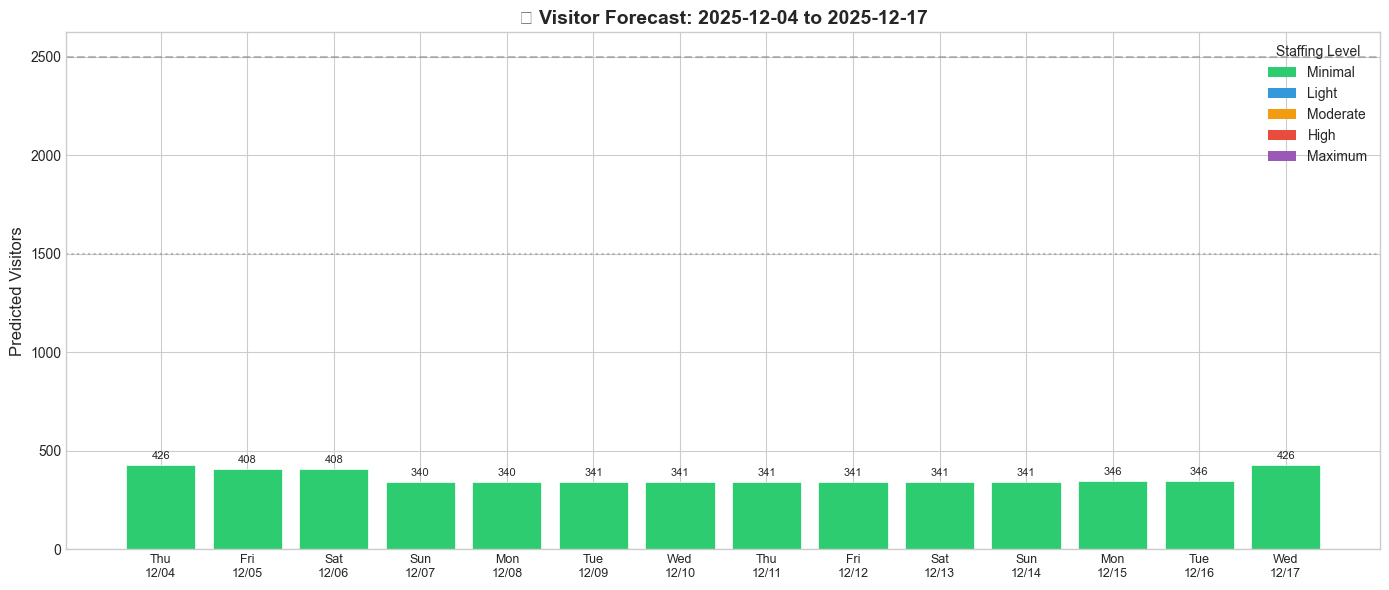

In [14]:
# ============================================================================
# VISUALIZATION: FORECAST TIMELINE
# ============================================================================
fig, ax = plt.subplots(figsize=(14, 6))

# Color bars by staffing level
colors = {
    'Minimal': '#2ecc71',
    'Light': '#3498db',
    'Moderate': '#f39c12',
    'High': '#e74c3c',
    'Maximum': '#9b59b6'
}

bar_colors = [colors[level] for level in results['staffing_level']]
bars = ax.bar(range(len(results)), results['predicted_visitors'], color=bar_colors, edgecolor='white', linewidth=0.5)

# Labels
ax.set_xticks(range(len(results)))
ax.set_xticklabels([f"{d.strftime('%a')}\n{d.strftime('%m/%d')}" for d in results['date']], fontsize=9)
ax.set_ylabel('Predicted Visitors', fontsize=12)
ax.set_title(f'🎿 Visitor Forecast: {FORECAST_START} to {FORECAST_START + timedelta(days=FORECAST_DAYS-1)}', fontsize=14, fontweight='bold')

# Add value labels on bars
for bar, val in zip(bars, results['predicted_visitors']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
            f'{val:,}', ha='center', va='bottom', fontsize=8)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=l) for l, c in colors.items()]
ax.legend(handles=legend_elements, title='Staffing Level', loc='upper right')

# Reference lines
ax.axhline(y=2500, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=1500, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()


## 5. Log Predictions & Summary


In [17]:
# ============================================================================
# LOG PREDICTIONS FOR OBSERVABILITY
# ============================================================================
logged_count = 0

for i, row in results.iterrows():
    try:
        # Convert row features to dict for logging
        features_dict = {k: float(v) for k, v in input_df.iloc[i].to_dict().items()}
        features_json = json.dumps(features_dict)
        
        # Use INSERT ... SELECT (not VALUES) because PARSE_JSON is a function
        session.sql(f"""
            INSERT INTO SKI_RESORT_DB.MARTS.ML_PREDICTION_LOG 
            (model_name, model_version, input_date, predicted_visitors, 
             features_json, request_source)
            SELECT 
                'VISITOR_FORECASTER', 
                '{model_version.version_name}',
                '{row['date'].strftime('%Y-%m-%d')}',
                {row['predicted_visitors']},
                PARSE_JSON($${features_json}$$),
                'notebook_batch'
        """).collect()
        logged_count += 1
    except Exception as e:
        print(f"   Warning: Could not log {row['date']}: {e}")

print(f"\n✅ Logged {logged_count} predictions to ML_PREDICTION_LOG")



✅ Logged 14 predictions to ML_PREDICTION_LOG


In [16]:
# ============================================================================
# GENERATE SUMMARY REPORT
# ============================================================================
peak_day = results.loc[results['predicted_visitors'].idxmax()]
low_day = results.loc[results['predicted_visitors'].idxmin()]

print("="*60)
print("📊 VISITOR FORECAST SUMMARY REPORT")
print("="*60)
print(f"\n📅 Forecast Period: {FORECAST_START} to {FORECAST_START + timedelta(days=FORECAST_DAYS-1)}")
print(f"🤖 Model: VISITOR_FORECASTER v{model_version.version_name}")
print(f"📝 Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print(f"\n📈 Visitor Predictions:")
print(f"   Total Expected: {results['predicted_visitors'].sum():,} visitors")
print(f"   Daily Average: {results['predicted_visitors'].mean():,.0f} visitors")
print(f"   Peak Day: {peak_day['day_name']} {peak_day['date'].strftime('%m/%d')} ({peak_day['predicted_visitors']:,} visitors)")
print(f"   Lowest Day: {low_day['day_name']} {low_day['date'].strftime('%m/%d')} ({low_day['predicted_visitors']:,} visitors)")

print(f"\n👥 Staffing Recommendations:")
for level in colors.keys():
    count = (results['staffing_level'] == level).sum()
    if count > 0:
        days = results[results['staffing_level'] == level]['day_name'].tolist()
        print(f"   {level}: {count} day(s) - {', '.join(days[:3])}{'...' if len(days) > 3 else ''}")

print(f"\n⚠️ Action Items:")
high_days = results[results['staffing_level'].isin(['High', 'Maximum'])]
if len(high_days) > 0:
    print(f"   🔴 {len(high_days)} high-volume day(s) require full staffing")
    for _, row in high_days.iterrows():
        print(f"      - {row['day_name']} {row['date'].strftime('%m/%d')}: {row['predicted_visitors']:,} visitors")
else:
    print("   ✅ No high-volume days in forecast period")

print("\n" + "="*60)


📊 VISITOR FORECAST SUMMARY REPORT

📅 Forecast Period: 2025-12-04 to 2025-12-17
🤖 Model: VISITOR_FORECASTER vSOLID_BADGER_4
📝 Generated: 2025-12-03 12:49:42

📈 Visitor Predictions:
   Total Expected: 5,086 visitors
   Daily Average: 363 visitors
   Peak Day: Thursday 12/04 (426 visitors)
   Lowest Day: Sunday 12/07 (340 visitors)

👥 Staffing Recommendations:
   Minimal: 14 day(s) - Thursday, Friday, Saturday...

⚠️ Action Items:
   ✅ No high-volume days in forecast period

